#  CV Homework 3 — Stereo Vision, Depth & Object Size Estimation

---

##  Overview
In this homework, you will build your own **stereo camera setup** using two webcameras or smartphones, perform **stereo calibration**, compute **depth maps**, detect **humans using YOLO**, and estimate **real-world distances** and **object sizes**.

---

### Important Notes
- You **must capture your own stereo images**.  
- Disable autofocus on your cameras and fix the focal length for all the captured images.  
- Keep cameras static during capture.  
- Capture a **checkerboard calibration dataset** and **scene images** with people and a reference object (cup).

---

## Goals
1. Calibrate a stereo camera using OpenCV.
2. Compute disparity and depth maps.
3. Detect humans with YOLO.
4. Estimate distances to humans.
5. Estimate a person’s height using a known-size reference object (cup).

---


## Part I — Stereo Camera Calibration

###  Task 1: Capture Checkerboard Images (5%)
Capture **N pairs** of checkerboard images using your stereo setup (more than 10 pairs for better results).

- The checkerboard must be visible from both cameras.  
- Save images as `left01.jpg`, `right01.jpg`, `left02.jpg`, `right02.jpg`, ...  


In [40]:
import os
import re
import cv2
import matplotlib.pyplot as plt
import numpy as np

BOARD_SIZE = (11, 7)
NUM_PAIRS = 14
LEFT_SIZE = cv2.imread("dataset/left01.jpeg").shape[:2]
RIGHT_SIZE = cv2.imread("dataset/right01.jpeg").shape[:2]

def rename(folder: str):
    for sub in ["left", "right"]:
        for img_name in os.listdir(os.path.join(folder, sub)):
            idx = re.match(r"photo_([0-9]*)_*", img_name).group(1)
            idx = int(idx)
            new_name = f"{sub}{idx:02d}.jpeg"
            os.rename(
                os.path.join(folder, sub, img_name),
                os.path.join(folder, new_name)
            )

def show_in_row(list_of_images: list, titles: list = None, disable_ticks: bool = True):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
    subplot.axis('off')
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

def read_one(filename: str, fx: float = 0.5, fy: float = 0.5):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, None, fx=fx, fy=fy)
    return img

def read_images():
    images = [
        [
            read_one(f"dataset/left{i:02d}.jpeg")
            for i in range(1, NUM_PAIRS + 1)
        ],
        [
            read_one(f"dataset/right{i:02d}.jpeg")
            for i in range(1, NUM_PAIRS + 1)
        ]
    ]
    return images[0] + images[1]



### Task 2: Detect Checkerboard Corners (5%)

Processing pair 01...


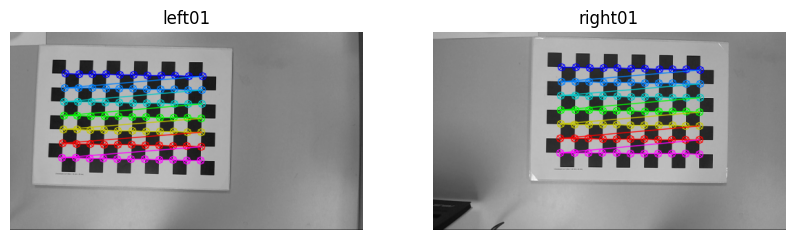

Pair 01... OK
Processing pair 02...


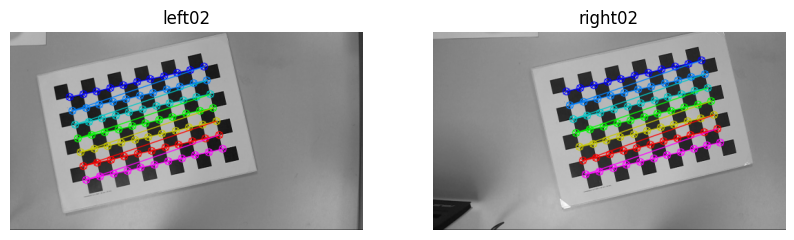

Pair 02... OK
Processing pair 03...


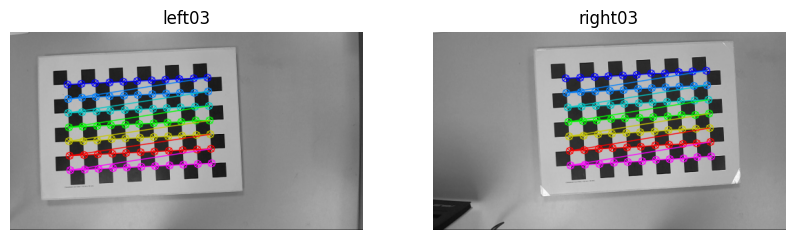

Pair 03... OK
Processing pair 04...


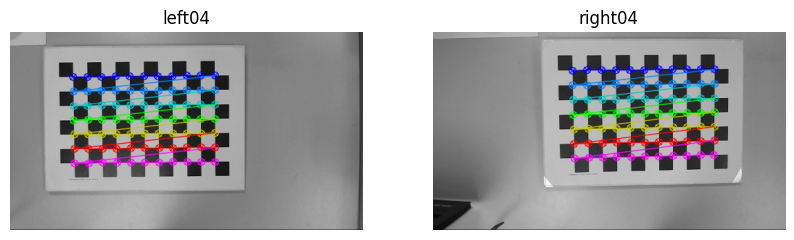

Pair 04... OK
Processing pair 05...


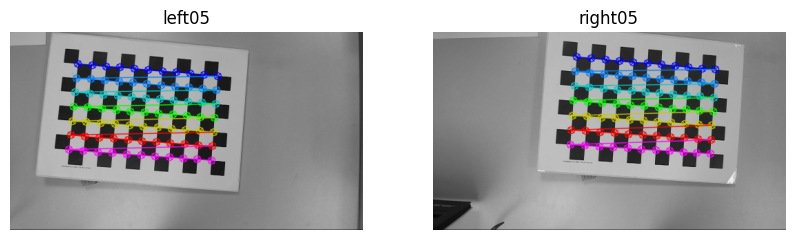

Pair 05... OK
Processing pair 06...


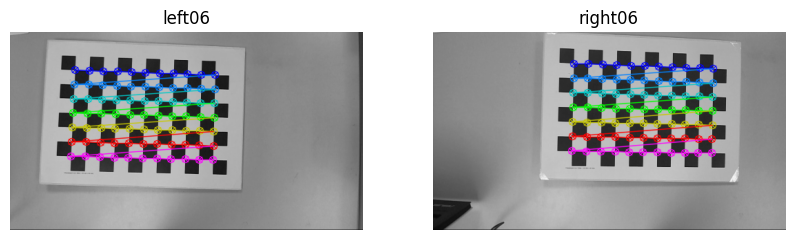

Pair 06... OK
Processing pair 07...


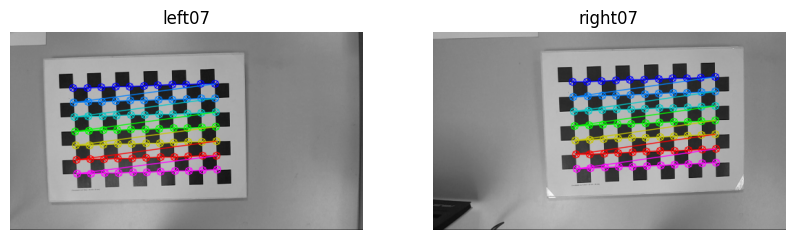

Pair 07... OK
Processing pair 08...


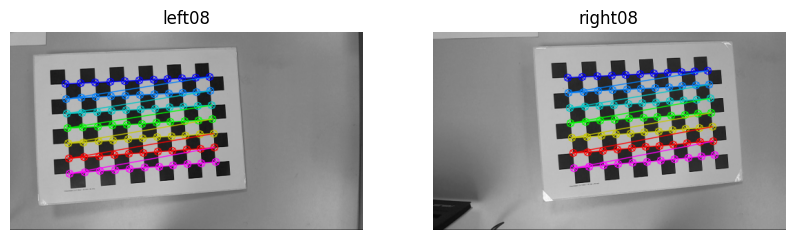

Pair 08... OK
Processing pair 09...


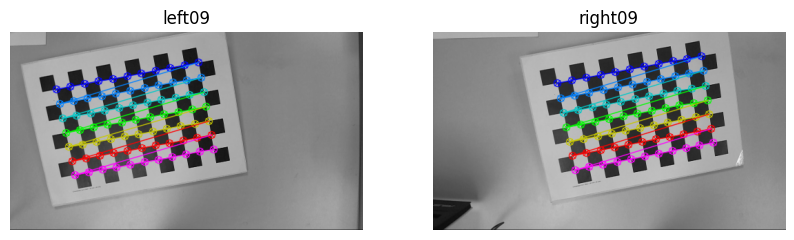

Pair 09... OK
Processing pair 10...


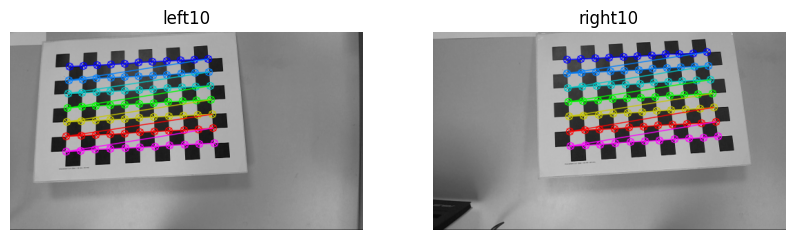

Pair 10... OK
Processing pair 11...


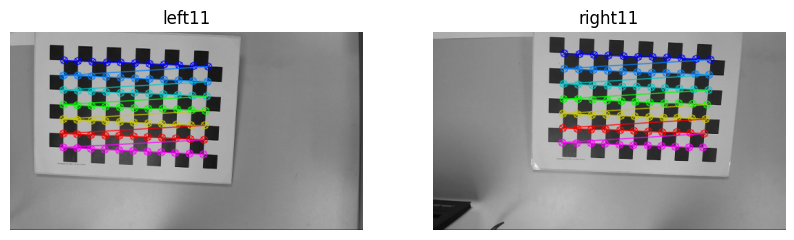

Pair 11... OK
Processing pair 12...


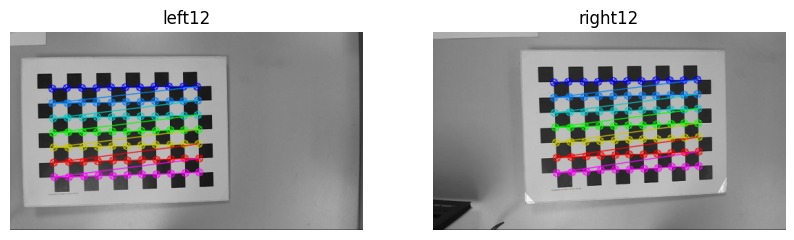

Pair 12... OK
Processing pair 13...


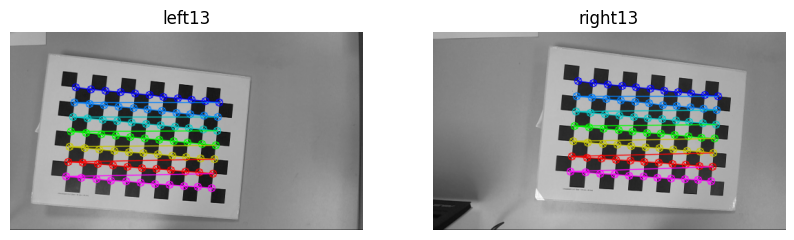

Pair 13... OK
Processing pair 14...


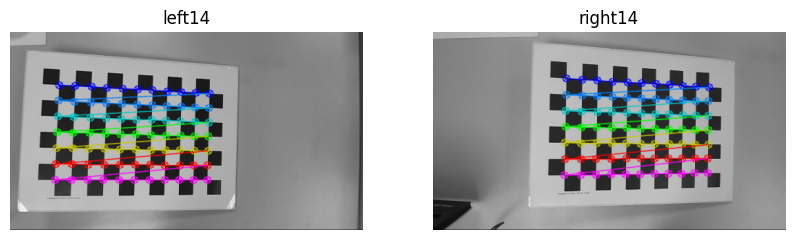

Pair 14... OK


In [41]:
def find_and_show_corners(images, board_size=BOARD_SIZE, figsize=(10, 5)):
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    
    obj_points = []
    img_points_left = []
    img_points_right = []

    
    objp = np.zeros((board_size[0] * board_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:board_size[0], 0:board_size[1]].T.reshape(-1, 2)

    for i in range(NUM_PAIRS):
        left_img = images[i]
        right_img = images[i + NUM_PAIRS]

        print(f"Processing pair {i+1:02d}...")

        pair_titles = [f"left{i+1:02d}", f"right{i+1:02d}"]
        pair_with_corners = []

        found_pair = True

        for side, img in zip(["left", "right"], [left_img, right_img]):
            gray = img if len(img.shape) == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            found, corners = cv2.findChessboardCorners(gray, board_size, None)

            if not found:
                print(f"  Chessboard not found on {side}{i+1:02d}")
                found_pair = False
                
                pair_with_corners.append(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB))
                continue

            
            corners2 = cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), criteria)

            
            img_corners = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
            cv2.drawChessboardCorners(img_corners, board_size, corners2, found)
            pair_with_corners.append(img_corners)

            
            if side == "left":
                img_points_left.append(corners2)
            else:
                img_points_right.append(corners2)

       
        if found_pair:
            obj_points.append(objp)

       
        plt.figure(figsize=figsize)
        show_in_row(pair_with_corners, titles=pair_titles)
        print(f"Pair {i+1:02d}... {'OK' if found_pair else 'Corners missing'}")

    return obj_points, img_points_left, img_points_right


images = read_images()




obj_points, img_points_left, img_points_right = find_and_show_corners(images)


### Task 3: Calibrate Each Camera (5%)

In [42]:
def calibrate_single_camera(obj_points, img_points, image_size, camera_name="left"):
    
    print(f"\nCalibrating {camera_name} camera...")

    
    ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(
        objectPoints=obj_points,
        imagePoints=img_points,
        imageSize=image_size,
        cameraMatrix=None,
        distCoeffs=None
    )
    
    print(ret)

    if not ret:
        print(f"⚠️ Calibration failed for {camera_name} camera")
    else:
        print(f"✅ {camera_name.capitalize()} camera calibrated successfully")
        print(f"Camera matrix ({camera_name}):\n{cameraMatrix}")
        print(f"Distortion coefficients ({camera_name}):\n{distCoeffs.ravel()}")

    return cameraMatrix, distCoeffs, rvecs, tvecs

CALIBRATION_SIZE = (LEFT_SIZE[1] // 2, LEFT_SIZE[0] // 2)  

left_cameraMatrix, left_distCoeffs, left_rvecs, left_tvecs = calibrate_single_camera(
    obj_points, img_points_left, CALIBRATION_SIZE, "left"
)

right_cameraMatrix, right_distCoeffs, right_rvecs, right_tvecs = calibrate_single_camera(
    obj_points, img_points_right, CALIBRATION_SIZE, "right"
)


Calibrating left camera...
0.11678469802601799
✅ Left camera calibrated successfully
Camera matrix (left):
[[     373.92           0      263.16]
 [          0      379.73      142.38]
 [          0           0           1]]
Distortion coefficients (left):
[    0.04138    -0.25923  0.00065158 -0.00047684     0.36816]

Calibrating right camera...
0.1241141602188802
✅ Right camera calibrated successfully
Camera matrix (right):
[[      372.4           0      258.05]
 [          0      377.98      145.22]
 [          0           0           1]]
Distortion coefficients (right):
[   0.019488     -0.2638  -0.0015801   0.0016396     0.62671]


### Task 4: Stereo Calibration (5%)

In [43]:
def stereo_calibrate(
    obj_points, img_points_left, img_points_right,
    left_cameraMatrix, left_distCoeffs,
    right_cameraMatrix, right_distCoeffs,
    image_size  # ← должен быть (512, 288)
):
    print("\nPerforming stereo calibration...")

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)
    flags = cv2.CALIB_FIX_INTRINSIC

    ret, _, _, _, _, R, T, E, F = cv2.stereoCalibrate(
        objectPoints=obj_points,
        imagePoints1=img_points_left,
        imagePoints2=img_points_right,
        cameraMatrix1=left_cameraMatrix,
        distCoeffs1=left_distCoeffs,
        cameraMatrix2=right_cameraMatrix,
        distCoeffs2=right_distCoeffs,
        imageSize=image_size,  # ← КРИТИЧНО: (512, 288)
        criteria=criteria,
        flags=flags
    )

    print(f"Stereo reprojection error: {ret:.4f} px")

    if ret < 1.0:
        print("Stereo calibration: EXCELLENT")
    elif ret < 2.0:
        print("Stereo calibration: GOOD")
    else:
        print("Stereo calibration: CHECK DATA")

    baseline = np.linalg.norm(T)
    print(f"Baseline (in world units): {baseline:.3f}")
    print(f"Translation T: {T.ravel()}")
    print(f"Rotation R:\n{R}")

    return R, T, E, F, ret


CALIBRATION_SIZE = (512, 288)  # (width, height)

R, T, E, F, error = stereo_calibrate(
    obj_points, img_points_left, img_points_right,
    left_cameraMatrix, left_distCoeffs,
    right_cameraMatrix, right_distCoeffs,
    image_size=CALIBRATION_SIZE
)


Performing stereo calibration...
Stereo reprojection error: 0.1279 px
Stereo calibration: EXCELLENT
Baseline (in world units): 6.415
Translation T: [     6.4144    -0.09328  -0.0025351]
Rotation R:
[[    0.99924   0.0073626   -0.038322]
 [  -0.008377     0.99962   -0.026377]
 [   0.038113    0.026678     0.99892]]


###  Task 5: Rectification and Map Creationv (5%)


Performing stereo rectification and map creation...
✅ Rectification and map creation successful
Left rectification matrix (R1):
[[    0.99924  -0.0071839   -0.038329]
 [  0.0066692     0.99989   -0.013538]
 [   0.038422    0.013272     0.99917]]
Right rectification matrix (R2):
[[    0.99989   -0.014541 -0.00039518]
 [   0.014545      0.9998    0.013405]
 [ 0.00020018    -0.01341     0.99991]]
Left projection matrix (P1):
[[     418.68           0      270.86           0]
 [          0      418.68      143.74           0]
 [          0           0           1           0]]
Right projection matrix (P2):
[[     418.68           0      270.86      2685.9]
 [          0      418.68      143.74           0]
 [          0           0           1           0]]
Disparity-to-depth mapping matrix (Q):
[[          1           0           0     -270.86]
 [          0           1           0     -143.74]
 [          0           0           0      418.68]
 [          0           0    -0.15588      

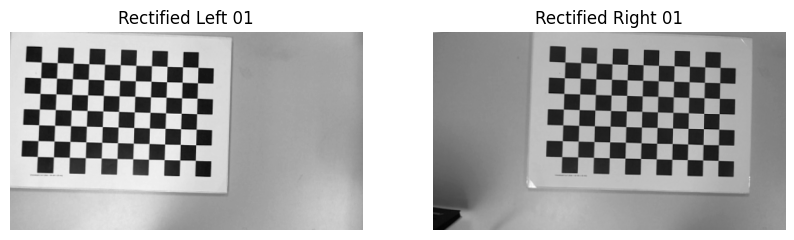

Showing rectified pair 01


In [44]:
def rectify_and_create_maps(R, T, left_cameraMatrix, left_distCoeffs, 
                           right_cameraMatrix, right_distCoeffs, image_size):
    """
    Rectifies the stereo pair and creates maps for image undistortion and rectification.
    Returns rectification transforms, projection matrices, and rectification maps.
    """
    print("\nPerforming stereo rectification and map creation...")

    # Stereo rectification
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        cameraMatrix1=left_cameraMatrix,
        distCoeffs1=left_distCoeffs,
        cameraMatrix2=right_cameraMatrix,
        distCoeffs2=right_distCoeffs,
        imageSize=image_size,
        R=R,
        T=T,
        flags=cv2.CALIB_ZERO_DISPARITY,  # Align principal points
        alpha=0  # Include all pixels, even with black borders
    )

    # Create rectification maps
    map1_left, map2_left = cv2.initUndistortRectifyMap(
        cameraMatrix=left_cameraMatrix,
        distCoeffs=left_distCoeffs,
        R=R1,
        newCameraMatrix=P1,
        size=image_size,
        m1type=cv2.CV_32FC1
    )

    map1_right, map2_right = cv2.initUndistortRectifyMap(
        cameraMatrix=right_cameraMatrix,
        distCoeffs=right_distCoeffs,
        R=R2,
        newCameraMatrix=P2,
        size=image_size,
        m1type=cv2.CV_32FC1
    )

    print("✅ Rectification and map creation successful")
    print(f"Left rectification matrix (R1):\n{R1}")
    print(f"Right rectification matrix (R2):\n{R2}")
    print(f"Left projection matrix (P1):\n{P1}")
    print(f"Right projection matrix (P2):\n{P2}")
    print(f"Disparity-to-depth mapping matrix (Q):\n{Q}")
    print(f"Left ROI: {roi1}")
    print(f"Right ROI: {roi2}")
    print(f"Map1 left shape: {map1_left.shape}, Map2 left shape: {map2_left.shape}")
    print(f"Map1 right shape: {map1_right.shape}, Map2 right shape: {map2_right.shape}")
    print(f"Map1 left sample values:\n{map1_left[:5, :5]}")
    print(f"Map2 left sample values:\n{map2_left[:5, :5]}")
    print(f"Map1 right sample values:\n{map1_right[:5, :5]}")
    print(f"Map2 right sample values:\n{map2_right[:5, :5]}")

    return R1, R2, P1, P2, Q, map1_left, map2_left, map1_right, map2_right, roi1, roi2

# Perform rectification and map creation
R1, R2, P1, P2, Q, map1_left, map2_left, map1_right, map2_right, roi1, roi2 = rectify_and_create_maps(
    R=R,
    T=T,
    left_cameraMatrix=left_cameraMatrix,
    left_distCoeffs=left_distCoeffs,
    right_cameraMatrix=right_cameraMatrix,
    right_distCoeffs=right_distCoeffs,
    image_size=CALIBRATION_SIZE  # ← ИСПРАВЛЕНО: (640, 480)
)

# Demonstrate rectification on one pair
def show_rectified_images(left_img, right_img, map1_left, map2_left, map1_right, map2_right, pair_idx=1):
    """
    Applies rectification maps to a pair of images and displays them.
    """
    print("Left image shape:", left_img.shape)
    print("Right image shape:", right_img.shape)
    print("Map1 left shape:", map1_left.shape)
    print("Map2 left shape:", map2_left.shape)
    print("Map1 right shape:", map1_right.shape)
    print("Map2 right shape:", map2_right.shape)
    
    # Проверяем, что изображения не пустые
    print("Left image sum before remap:", left_img.sum())
    print("Right image sum before remap:", right_img.sum())
    
    rectified_left = cv2.remap(left_img, map1_left, map2_left, cv2.INTER_LINEAR)
    rectified_right = cv2.remap(right_img, map1_right, map2_right, cv2.INTER_LINEAR)
    
    print("Rectified left image sum:", rectified_left.sum())
    print("Rectified right image sum:", rectified_right.sum())
    
    plt.figure(figsize=(10, 5))
    show_in_row(
        [rectified_left, rectified_right],
        titles=[f"Rectified Left {pair_idx:02d}", f"Rectified Right {pair_idx:02d}"]
    )
    print(f"Showing rectified pair {pair_idx:02d}")
    
    # Сохраняем изображения для отладки
    cv2.imwrite(f"rectified_left_{pair_idx:02d}.jpg", rectified_left)
    cv2.imwrite(f"rectified_right_{pair_idx:02d}.jpg", rectified_right)

# Example: Rectify and show the first pair
left_img = read_one("dataset/left01.jpeg")
right_img = read_one("dataset/right01.jpeg")
show_rectified_images(left_img, right_img, map1_left, map2_left, map1_right, map2_right, pair_idx=1)

## Part II — Depth Map Computation (15%)

In [45]:

left_img = cv2.imread("people/people_left.jpg")
right_img = cv2.imread("people/people_right.jpg")


grayL = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)


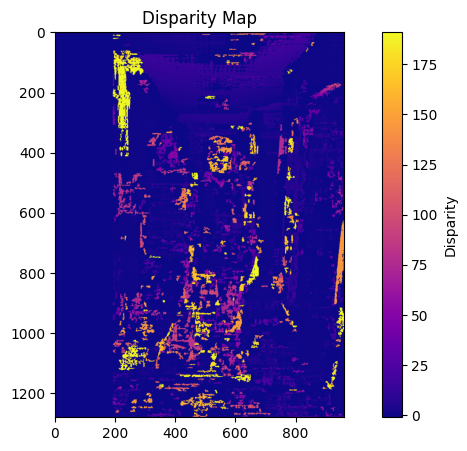

In [46]:

window_size = 5
min_disp = 0
num_disp = 16 * 12

stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=window_size,
    P1=8 * 3 * window_size**2,
    P2=32 * 3 * window_size**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=50,
    speckleRange=16,
    preFilterCap=31,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)


disparity = stereo.compute(grayL, grayR).astype(np.float32) / 16.0


plt.figure(figsize=(10,5))
plt.imshow(disparity, cmap='plasma')
plt.colorbar(label='Disparity')
plt.title("Disparity Map")
plt.show()


points_3D = cv2.reprojectImageTo3D(disparity, Q)
depth = points_3D[:, :, 2]


## Part III — Human Detection (YOLO) (10%)


0: 640x480 2 persons, 267.0ms
Speed: 10.1ms preprocess, 267.0ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 480)


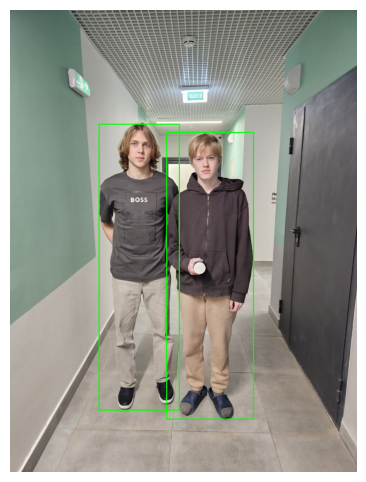

In [47]:
from ultralytics import YOLO



model = YOLO("yolov8n.pt")


left_image = cv2.imread("people/people_left.jpg")


results = model(left_image)


people_detections = []
for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        name = model.names[cls]
        if name == 'person':
            people_detections.append(box)


for box in people_detections:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    conf = float(box.conf[0])
    cv2.rectangle(left_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    


left_image_rgb = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10,6))
plt.imshow(left_image_rgb)
plt.axis('off')
plt.show()


## Part IV — Distance Estimation (20%)

distance: 1.0461030235215403
distance: 1.601114463720748


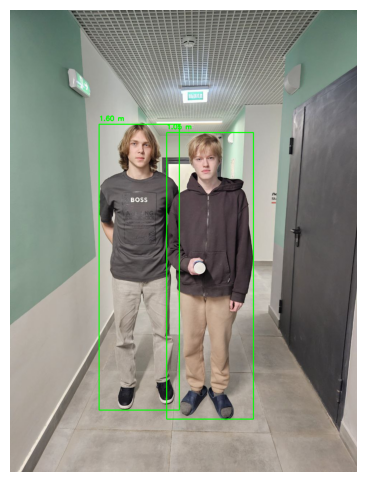

In [48]:

square_size_mm = 25.0   
square_size_m = square_size_mm / 1000.0

f = Q[2,3]
baseline_raw = -1.0 / Q[3,2]
baseline_m = baseline_raw * square_size_m



output_img = left_image.copy()

for box in people_detections:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    person_disp = disparity[y1:y2, x1:x2]
    valid = person_disp[np.isfinite(person_disp) & (person_disp > 0)]

    if valid.size > 0:
        median_disp = np.median(valid)
        mean_disp = np.mean(valid)
        Z_m = (f * baseline_m) / (median_disp + 1e-6)
        label = f"{Z_m:.2f} m"
    else:
        median_disp = None
        Z_m = np.nan
        label = "N/A"

    print(f"distance: {Z_m}")

    cv2.rectangle(output_img, (x1,y1), (x2,y2), (0,255,0), 2)
    cv2.putText(output_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Part V — Height Estimation via Known Object (Cup) (10%)

### Scenario
The scene must include **two people**, one of them holding a **cup** showing its **bottom circle**.  
The **diameter of the cup is known** (e.g., 0.07 m).

You will:
1. Detect the cup’s circular bottom with the **Hough Circle Transform**.  
2. Measure the circle’s apparent diameter in pixels.  
3. Compute the pixel-to-meter ratio.  
4. Use YOLO bounding boxes to measure a person’s pixel height.  
5. Estimate real height in meters.


In [59]:

cup_diameter_m = 0.074

image = cv2.imread("people/people_right.jpg")


model = YOLO("yolov8n.pt")
results = model(image)

people_boxes = []
for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        name = model.names[cls]
        if name == 'person':
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            people_boxes.append((x1, y1, x2, y2))
            cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)


holder_box = people_boxes[0] 
x1, y1, x2, y2 = holder_box
hand_roi = image[y1:int(y1 + (y2 - y1) * 0.7), x1:x2] 

gray = cv2.cvtColor(hand_roi, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7,7), 1.5)

circles = cv2.HoughCircles(
    gray,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=20,
    param1=50,
    param2=25,
    minRadius=5,
    maxRadius=50
)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x, y, r) in circles[0, :]:
        cv2.circle(hand_roi, (x, y), r, (0, 0, 255), 2)
        cup_diameter_px = 2 * r
        break
else:
    raise ValueError("Не удалось найти дно чашки.")

pixel_to_meter = cup_diameter_m / cup_diameter_px






0: 640x480 2 persons, 158.1ms
Speed: 5.2ms preprocess, 158.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


Estimated second person height: 1.83 m


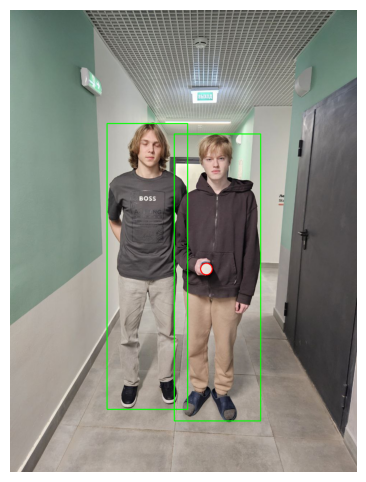

In [60]:
second_person_box = people_boxes[1]
x1, y1, x2, y2 = second_person_box
person_height_px = y2 - y1
person_height_m = person_height_px * pixel_to_meter

print(f"Estimated second person height: {person_height_m:.2f} m")

# --- Визуализация ---
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Reflection (10%)

Answer in Markdown cell:
1. What were the main sources of error in your calibration and measurements?  
2. How could you improve your stereo setup to achieve more accurate depth results?


---
###  Submission Instructions
- Submit this notebook with all code cells executed (file name should be YOUR_NAME_HW3).
- The code should be commented. (5%)
- Include a folder with your captured stereo images.
- Ensure all parameters are clearly documented.(5%)


# Useful resources :
- https://learnopencv.com/making-a-low-cost-stereo-camera-using-opencv/
- https://pub.towardsai.net/detecting-objects-with-yolov5-opencv-python-and-c-c7cf13d1483c
- https://learnopencv.com/introduction-to-epipolar-geometry-and-stereo-vision/